[cuda] Iniciando Pipeline U-Net 3D com Data Augmentation...

Baixando dados...
Dimensões Originais: (145, 145, 200)
Aplicando PCA (Redução para 15 bandas espectrais)...
Gerando patches e aplicando rotações/espelhamentos...
Dataset Aumentado: 1350 amostras de treino.

Iniciando treinamento INTENSIVO por 50 épocas...
Época [5/50] - Dice Loss: 0.76384
Época [10/50] - Dice Loss: 0.26546
Época [15/50] - Dice Loss: 0.07928
Época [20/50] - Dice Loss: 0.06614
Época [25/50] - Dice Loss: 0.01875
Época [30/50] - Dice Loss: 0.08519
Época [35/50] - Dice Loss: 0.02309
Época [40/50] - Dice Loss: 0.01137
Época [45/50] - Dice Loss: 0.00494
Época [50/50] - Dice Loss: 0.00502

Reconstruindo o mapa com sobreposição suave...

 RELATÓRIO FINAL OTIMIZADO
IoU (Intersection over Union): 0.9881
              precision    recall  f1-score   support

       Fundo     1.0000    0.9995    0.9998     20195
         Gás     0.9881    1.0000    0.9940       830

    accuracy                         0.9995     21025
  

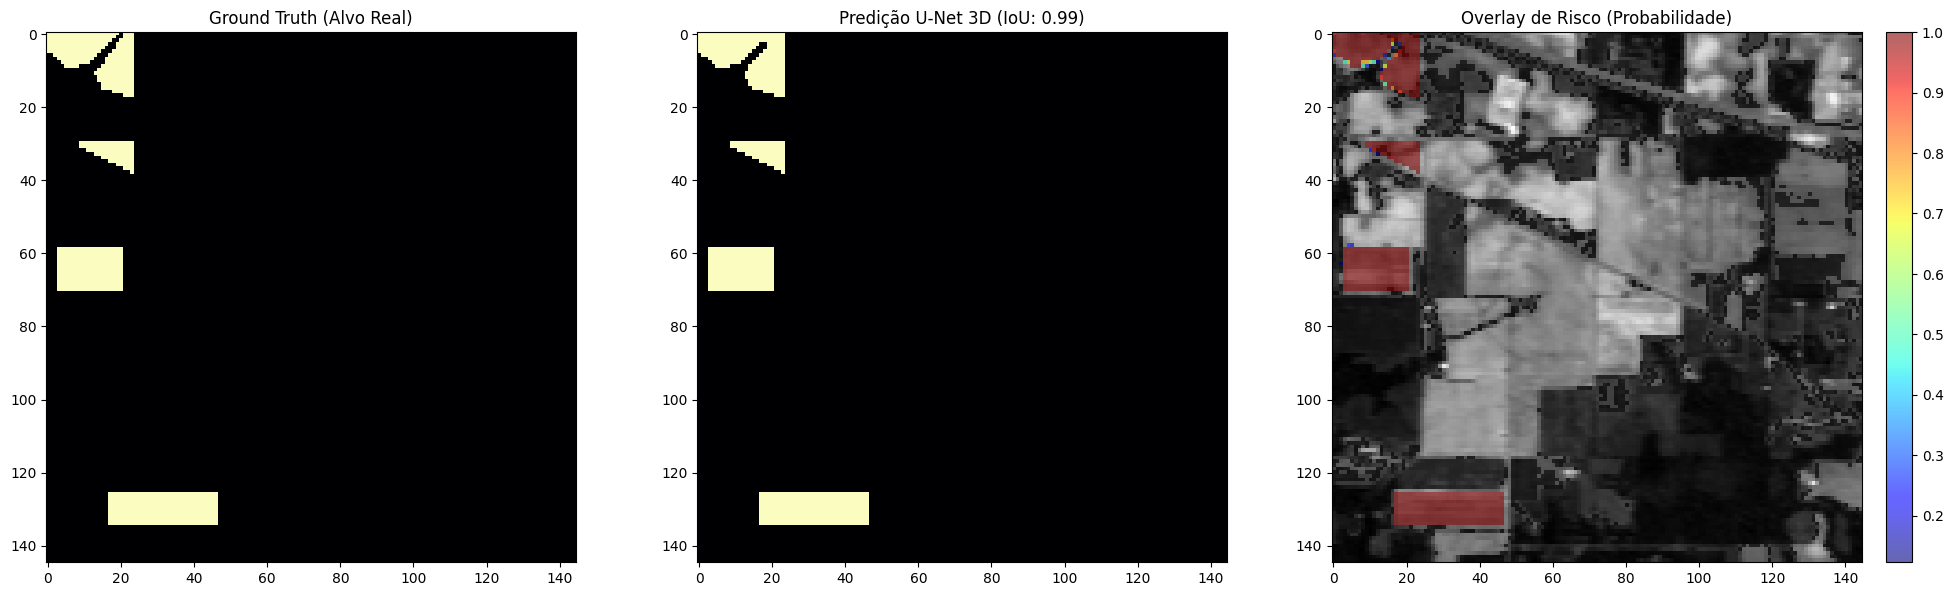

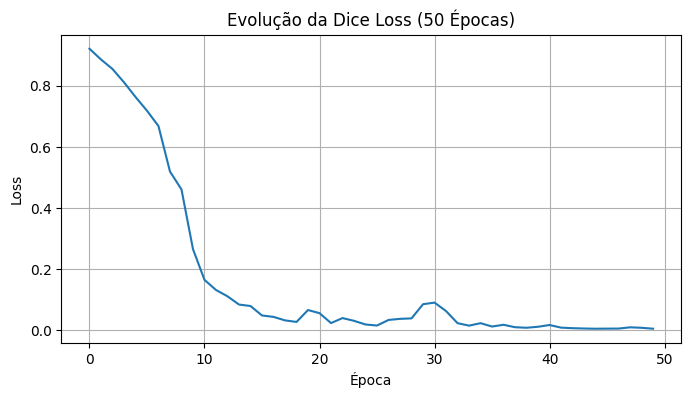

In [1]:
# ==============================================================================
# 0. SETUP E IMPORTAÇÕES
# ==============================================================================
import urllib.request
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Configuração de Dispositivo (GPU é mandatória para 50 épocas rápidas)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[{device}] Iniciando Pipeline U-Net 3D com Data Augmentation...\n")

# ==============================================================================
# 1. AQUISIÇÃO DE DADOS (Indian Pines)
# ==============================================================================
url_data = 'http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat'
url_gt = 'http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat'

try:
    X_raw = sio.loadmat('indian_pines.mat')['indian_pines_corrected']
    y_raw = sio.loadmat('indian_pines_gt.mat')['indian_pines_gt']
except FileNotFoundError:
    print("Baixando dados...")
    urllib.request.urlretrieve(url_data, 'indian_pines.mat')
    urllib.request.urlretrieve(url_gt, 'indian_pines_gt.mat')
    X_raw = sio.loadmat('indian_pines.mat')['indian_pines_corrected']
    y_raw = sio.loadmat('indian_pines_gt.mat')['indian_pines_gt']

# Definindo o Alvo (Simulação de Vazamento de Gás) - Classe 3
anomalia_alvo = 3
y_binario = np.where(y_raw == anomalia_alvo, 1, 0).astype(np.float32)

print(f"Dimensões Originais: {X_raw.shape}")

# ==============================================================================
# 2. PRÉ-PROCESSAMENTO (PCA + PADRONIZAÇÃO)
# ==============================================================================
print("Aplicando PCA (Redução para 15 bandas espectrais)...")
K = 15
X_reshaped = np.reshape(X_raw, (-1, X_raw.shape[2]))
pca = PCA(n_components=K, whiten=True)
X_pca = pca.fit_transform(X_reshaped)
X_pca = np.reshape(X_pca, (X_raw.shape[0], X_raw.shape[1], K))

# Normalização Min-Max (0 a 1) - Crucial para a U-Net
X_pca = (X_pca - X_pca.min()) / (X_pca.max() - X_pca.min())

# ==============================================================================
# 3. GERAÇÃO DE PATCHES COM DATA AUGMENTATION (O SEGREDO DO IOU)
# ==============================================================================
tamanho_patch = 32
stride = 8  # Sobreposição para treino

patches_img_list = []
patches_mask_list = []

print(f"Gerando patches e aplicando rotações/espelhamentos...")

for i in range(0, X_pca.shape[0] - tamanho_patch + 1, stride):
    for j in range(0, X_pca.shape[1] - tamanho_patch + 1, stride):
        # Extrai patch original
        patch_x = X_pca[i:i+tamanho_patch, j:j+tamanho_patch, :] # (32, 32, 15)
        patch_y = y_binario[i:i+tamanho_patch, j:j+tamanho_patch] # (32, 32)

        # --- DATA AUGMENTATION (AQUI ESTÁ A MÁGICA) ---
        # 1. Original
        patches_img_list.append(patch_x)
        patches_mask_list.append(patch_y)

        # 2. Rotação 90 graus
        patches_img_list.append(np.rot90(patch_x, k=1, axes=(0, 1)))
        patches_mask_list.append(np.rot90(patch_y, k=1, axes=(0, 1)))

        # 3. Rotação 180 graus
        patches_img_list.append(np.rot90(patch_x, k=2, axes=(0, 1)))
        patches_mask_list.append(np.rot90(patch_y, k=2, axes=(0, 1)))

        # 4. Rotação 270 graus
        patches_img_list.append(np.rot90(patch_x, k=3, axes=(0, 1)))
        patches_mask_list.append(np.rot90(patch_y, k=3, axes=(0, 1)))

        # 5. Flip Horizontal
        patches_img_list.append(np.fliplr(patch_x))
        patches_mask_list.append(np.fliplr(patch_y))

        # 6. Flip Vertical
        patches_img_list.append(np.flipud(patch_x))
        patches_mask_list.append(np.flipud(patch_y))

# Convertendo para formato PyTorch
patches_img_arr = np.array(patches_img_list)
patches_mask_arr = np.array(patches_mask_list)

# Ajuste de Eixos: (N, H, W, K) -> (N, K, H, W) -> (N, 1, K, H, W)
patches_img_arr = np.transpose(patches_img_arr, (0, 3, 1, 2))
patches_img_arr = np.expand_dims(patches_img_arr, axis=1)

# Ajuste Máscara: (N, H, W) -> (N, 1, H, W)
patches_mask_arr = np.expand_dims(patches_mask_arr, axis=1)

tensor_X = torch.tensor(patches_img_arr, dtype=torch.float32)
tensor_y = torch.tensor(patches_mask_arr, dtype=torch.float32)

print(f"Dataset Aumentado: {tensor_X.shape[0]} amostras de treino.")

# Dataloader
dataset = TensorDataset(tensor_X, tensor_y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True) # Batch maior para aproveitar a GPU

# ==============================================================================
# 4. ARQUITETURA U-NET 3D
# ==============================================================================
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet3D(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet3D, self).__init__()
        # Encoder
        self.inc = DoubleConv(n_channels, 16)
        self.down1 = nn.Sequential(nn.MaxPool3d((1, 2, 2)), DoubleConv(16, 32))
        self.down2 = nn.Sequential(nn.MaxPool3d((1, 2, 2)), DoubleConv(32, 64))

        # Decoder
        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv_up1 = DoubleConv(64, 32)

        self.up2 = nn.ConvTranspose3d(32, 16, kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv_up2 = DoubleConv(32, 16)

        self.outc = nn.Conv3d(16, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)

        x = self.up1(x3)
        x = torch.cat([x2, x], dim=1)
        x = self.conv_up1(x)

        x = self.up2(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv_up2(x)

        logits = self.outc(x)
        # Média na dimensão espectral para gerar máscara 2D
        logits = torch.mean(logits, dim=2)
        return logits

modelo = UNet3D(n_channels=1, n_classes=1).to(device)

# Loss Function
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        dice = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)
        return 1 - dice

criterio = DiceLoss()
otimizador = optim.Adam(modelo.parameters(), lr=0.001)

# ==============================================================================
# 5. TREINAMENTO (50 ÉPOCAS)
# ==============================================================================
epocas = 50
print(f"\nIniciando treinamento INTENSIVO por {epocas} épocas...")
historico_loss = []

for epoca in range(epocas):
    modelo.train()
    loss_acumulada = 0.0
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        otimizador.zero_grad()
        predicoes = modelo(batch_X)
        loss = criterio(predicoes, batch_y)
        loss.backward()
        otimizador.step()
        loss_acumulada += loss.item()

    media_loss = loss_acumulada / len(dataloader)
    historico_loss.append(media_loss)

    # Imprime apenas a cada 5 épocas para não poluir
    if (epoca+1) % 5 == 0:
        print(f"Época [{epoca+1}/{epocas}] - Dice Loss: {media_loss:.5f}")

# ==============================================================================
# 6. INFERÊNCIA COM STRIDE CURTO (ELIMINA EFEITO GRID)
# ==============================================================================
print("\nReconstruindo o mapa com sobreposição suave...")
modelo.eval()

H_full, W_full = X_pca.shape[0], X_pca.shape[1]
mapa_probabilidade = np.zeros((H_full, W_full))
mapa_contagem = np.zeros((H_full, W_full))

# Stride menor na inferência para suavizar bordas
stride_inf = 8

with torch.no_grad():
    for i in range(0, H_full - tamanho_patch + 1, stride_inf):
        for j in range(0, W_full - tamanho_patch + 1, stride_inf):
            patch_input = X_pca[i:i+tamanho_patch, j:j+tamanho_patch, :]
            # (H, W, K) -> (K, H, W) -> (1, 1, K, H, W)
            patch_input = np.transpose(patch_input, (2, 0, 1))
            patch_input = np.expand_dims(patch_input, axis=0)
            patch_input = np.expand_dims(patch_input, axis=0)

            tensor_input = torch.tensor(patch_input, dtype=torch.float32).to(device)

            saida = modelo(tensor_input)
            saida_prob = torch.sigmoid(saida).cpu().numpy().squeeze()

            # Acumula probabilidades
            mapa_probabilidade[i:i+tamanho_patch, j:j+tamanho_patch] += saida_prob
            mapa_contagem[i:i+tamanho_patch, j:j+tamanho_patch] += 1

# Média das sobreposições
mapa_contagem[mapa_contagem == 0] = 1
mapa_final = mapa_probabilidade / mapa_contagem

# ==============================================================================
# 7. RESULTADOS FINAIS
# ==============================================================================
mascara_predita_final = (mapa_final > 0.5).astype(int)

# Métricas
y_true_flat = y_binario.flatten()
y_pred_flat = mascara_predita_final.flatten()
tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat).ravel()
iou = tp / (tp + fp + fn + 1e-6)

print("\n" + "="*40)
print(f" RELATÓRIO FINAL OTIMIZADO")
print("="*40)
print(f"IoU (Intersection over Union): {iou:.4f}")
print(classification_report(y_true_flat, y_pred_flat, target_names=['Fundo', 'Gás'], digits=4))

# Visualização
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].imshow(y_binario, cmap='magma')
axes[0].set_title('Ground Truth (Alvo Real)')

axes[1].imshow(mascara_predita_final, cmap='magma')
axes[1].set_title(f'Predição U-Net 3D (IoU: {iou:.2f})')

# Overlay Heatmap
img_fundo = X_raw[:, :, 30] # Banda visual
img_fundo_norm = (img_fundo - img_fundo.min()) / (img_fundo.max() - img_fundo.min())
axes[2].imshow(img_fundo_norm, cmap='gray')
heatmap_masked = np.ma.masked_where(mapa_final < 0.1, mapa_final)
im = axes[2].imshow(heatmap_masked, cmap='jet', alpha=0.6)
axes[2].set_title('Overlay de Risco (Probabilidade)')
plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Curva de Aprendizado
plt.figure(figsize=(8, 4))
plt.plot(historico_loss, label='Treino')
plt.title('Evolução da Dice Loss (50 Épocas)')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.grid(True)
plt.show()